# Оглавление
**Listener** - программа, что переводит записанное вами аудио на микрофон/диктофон в набор нот, после чего накладывает их на нотный стан, с точностью до длительности.

**Данный файл** предназначен для ознакомления программиста со структурой библиотек librosa, numpy, и для изучения основ работы со звуком и физики звука.

Текущие задачи:
    - Научиться определять ноту, созвучную с гармоникой другой ноты от двух созвучных гармоник (обертонов)
    - Научиться определять ноту по её обертонам
    - Структурировать уже существующий код

Импорт необходимых библиотек:

In [1]:
import librosa
import numpy as np
import librosa.display
from matplotlib import  pyplot as plt
import math
import seaborn as sns

Загрузка файла и вывод основной информации.

In [2]:
audio_filename = '1.ogg'
sampling_rate = 48000
audio_file , sampling_rate = librosa.load(audio_filename,sr = sampling_rate)
print('Audio file type :', type(audio_file), '; Sample Rate type:', type(sampling_rate))
print('Audio file Shape:', audio_file.shape, '; Sample Rate =', sampling_rate)

duration = audio_file.shape[0]/sampling_rate
minutes = int(duration/60)
sec = int(duration-minutes*60)
print('Duration - {}:{} ({} sec)'.format(minutes,sec,duration))

/home/neil/.local/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Audio file type : <class 'numpy.ndarray'> ; Sample Rate type: <class 'int'>
Audio file Shape: (1137288,) ; Sample Rate = 48000
Duration - 0:23 (23.6935 sec)


---  
Отрезаю лишь нужную часть аудио для текущей обработки, либо работаю с целым файлом.

    - hop_length уменьшает с ростом кол-во данных о синусоидах в единицу времени
    - n_fft увеличивает с ростом кол-во данных о каждой из частот

In [3]:
start_sec = 0
start_timestamp = int(sampling_rate*start_sec)
ln = 2
end_timestamp = int(start_timestamp + sampling_rate*ln)
# stft = librosa.stft(audio_file[start_timestamp:end_timestamp], n_fft = 2**13, hop_length = int(100))
stft= librosa.stft(audio_file, n_fft = 2**15, hop_length = int(duration*4)*10)
print(stft.shape)

(16385, 1210)


**stft** - Матрица, хранящая децибелы в виде координаты [Частота, Фрейм]

Перевожу имеющиеся амплитудные данные в  Спектрограмму.

In [34]:
db = librosa.amplitude_to_db(abs(stft))
# plt.figure(figsize=(14, 6))
# plt.axis([0,96,0,1000])
# x, time_scale, hz_scale = librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log',hop_length = int(duration*4)*5)
# x, time_scale, hz_scale = librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log')
# plt.colorbar()

Пока-что очисткой от шумов будем считать удаление всех тех ячеек, где децибелы отрицательны

In [35]:
# db[db < db.mean()] = 0
db[db < 0] = 0

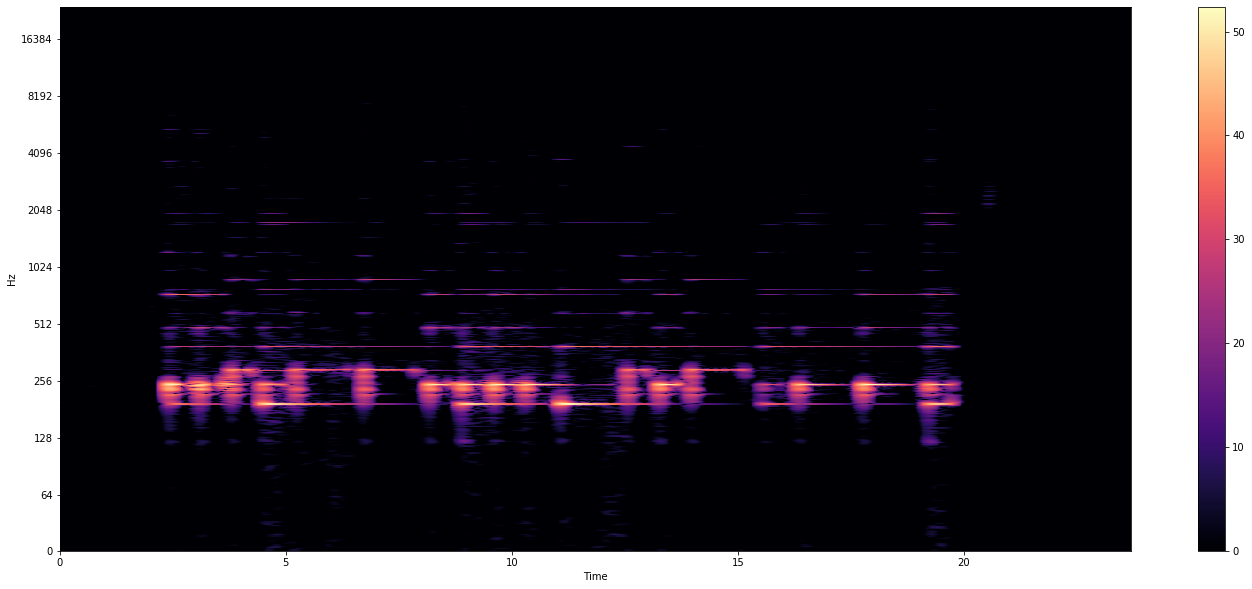

In [6]:
plt.figure(figsize=(24, 10))
x, time_scale, hz_scale = librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log',hop_length = int(duration*4)*10)
# librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log', hop_length = int(duration*4)*5)
plt.colorbar()

731.69  Hz, 2.94 sec


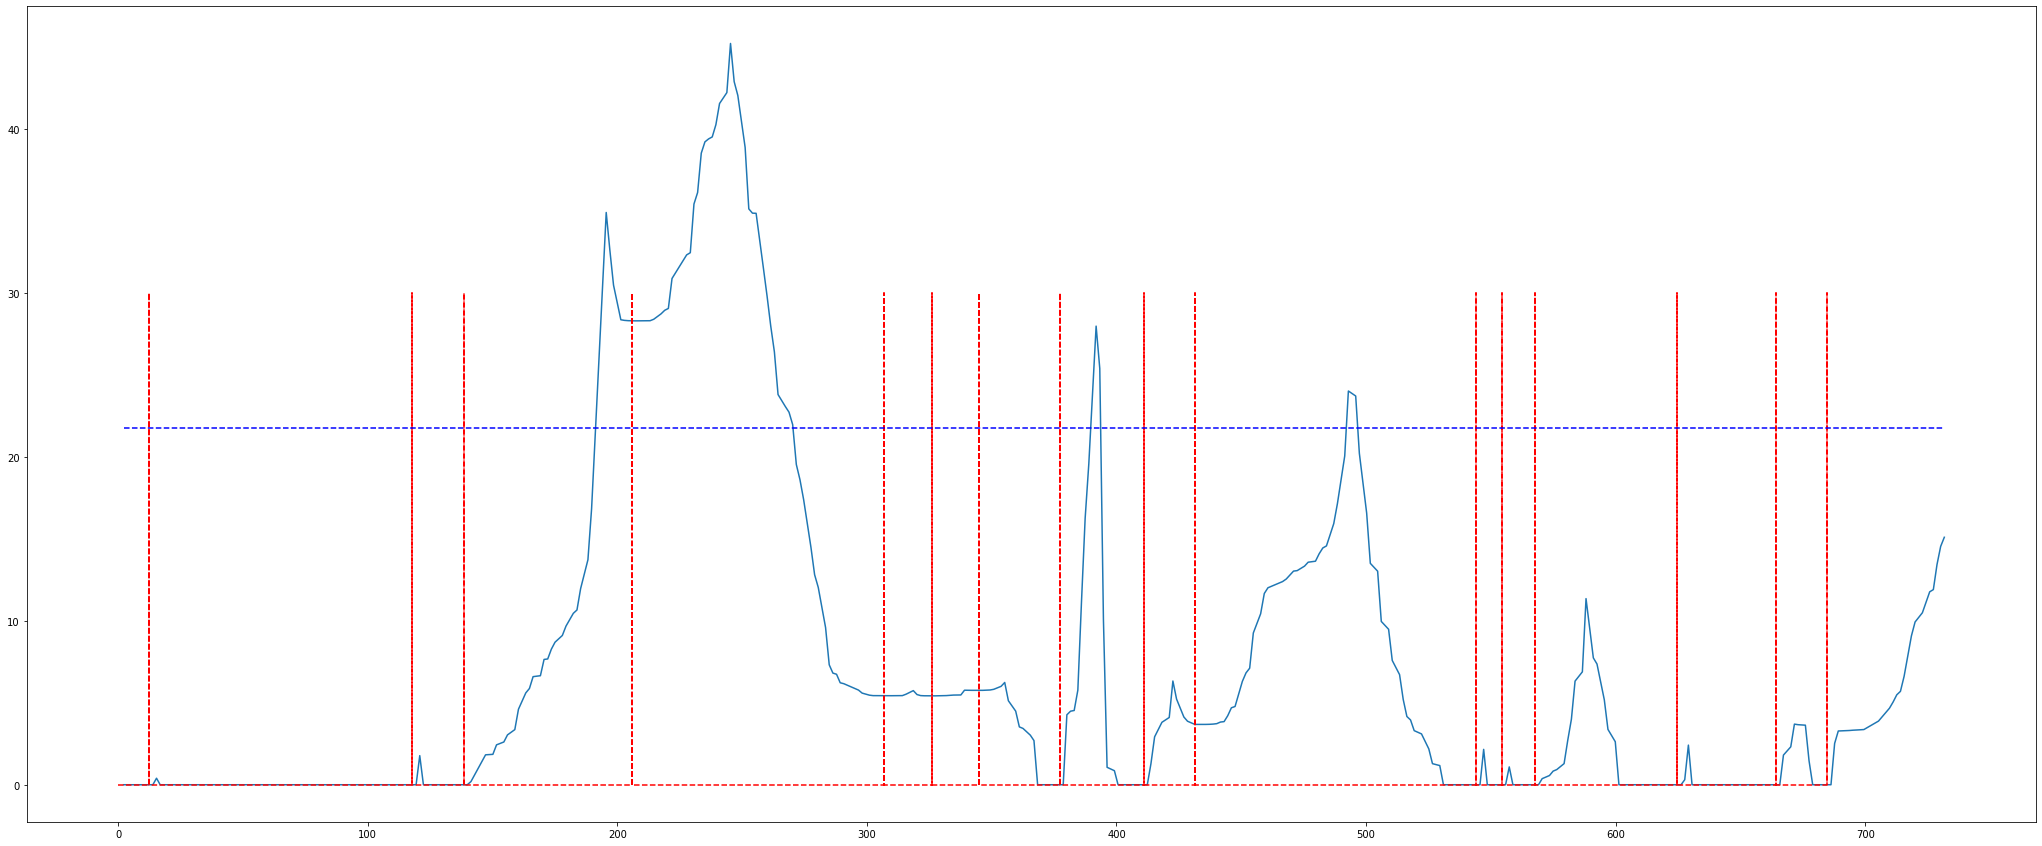

In [48]:
max_val = 500
frame = 150
print(round(hz_scale[max_val],2),' Hz,',round(duration*frame/db.shape[1],2),'sec')
# plt.figure(figsize=(36, 15))
# plt.plot(hz_scale[2: max_val + 1],db[1: max_val,frame])

def glancing(data, count, delta):
    if count > 0:
        for pos,elem in enumerate(data):
            for i in range(1,delta+1):
                if (pos > i) and (len(data) - pos > i) and elem < data[pos - i] and elem < data[pos + i]:
                    data[pos] = (data[pos - i] + data[pos + i])/2
        temp_db = glancing(data, count - 1, delta)
    return data
tdb = db[1: max_val, frame].copy()
tdb = glancing(tdb, 5, 3)
tdb = glancing(tdb, 5, 2)
tdb = glancing(tdb, 5, 1)


xs = [0]
ys = [0]

for pos,elem in enumerate(tdb):
    if (pos>0 and pos < len(tdb)-1) and (tdb[pos - 1] >= elem <= tdb[pos + 1]):
        if ys[-1] == hz_scale[pos]:
            ys[-1] = hz_scale[pos + 1]
            ys[-2] = hz_scale[pos + 1]
            ys[-3] = hz_scale[pos + 1]
        else:
            xs.append(0)
            ys.append(hz_scale[pos+1])
            xs.append(30)
            ys.append(hz_scale[pos+1])
            xs.append(0)
            ys.append(hz_scale[pos+1])

plt.figure(figsize=(36, 15))
plt.plot(hz_scale[2: max_val + 1],tdb, ys, xs,'r--', hz_scale[2: max_val + 1], [3*tdb.mean()]*len(tdb),'b--')
# plt.plot(hz_scale[2: max_val + 1],tdb)
# print(set(ys))

In [37]:
def glancing(data, count, delta):
    if count > 0:
        for pos,elem in enumerate(data):
            for i in range(1,delta+1):
                if (pos > i) and (len(data) - pos > i) and elem < data[pos - i] and elem < data[pos + i]:
                    data[pos] = (data[pos - i] + data[pos + i])/2
        temp_db = glancing(data, count - 1, delta)
    return data

def sample_glacer(data):
    data = glancing(data, 5, 3)
    data = glancing(data, 5, 2)
    data = glancing(data, 5, 1)
    return data

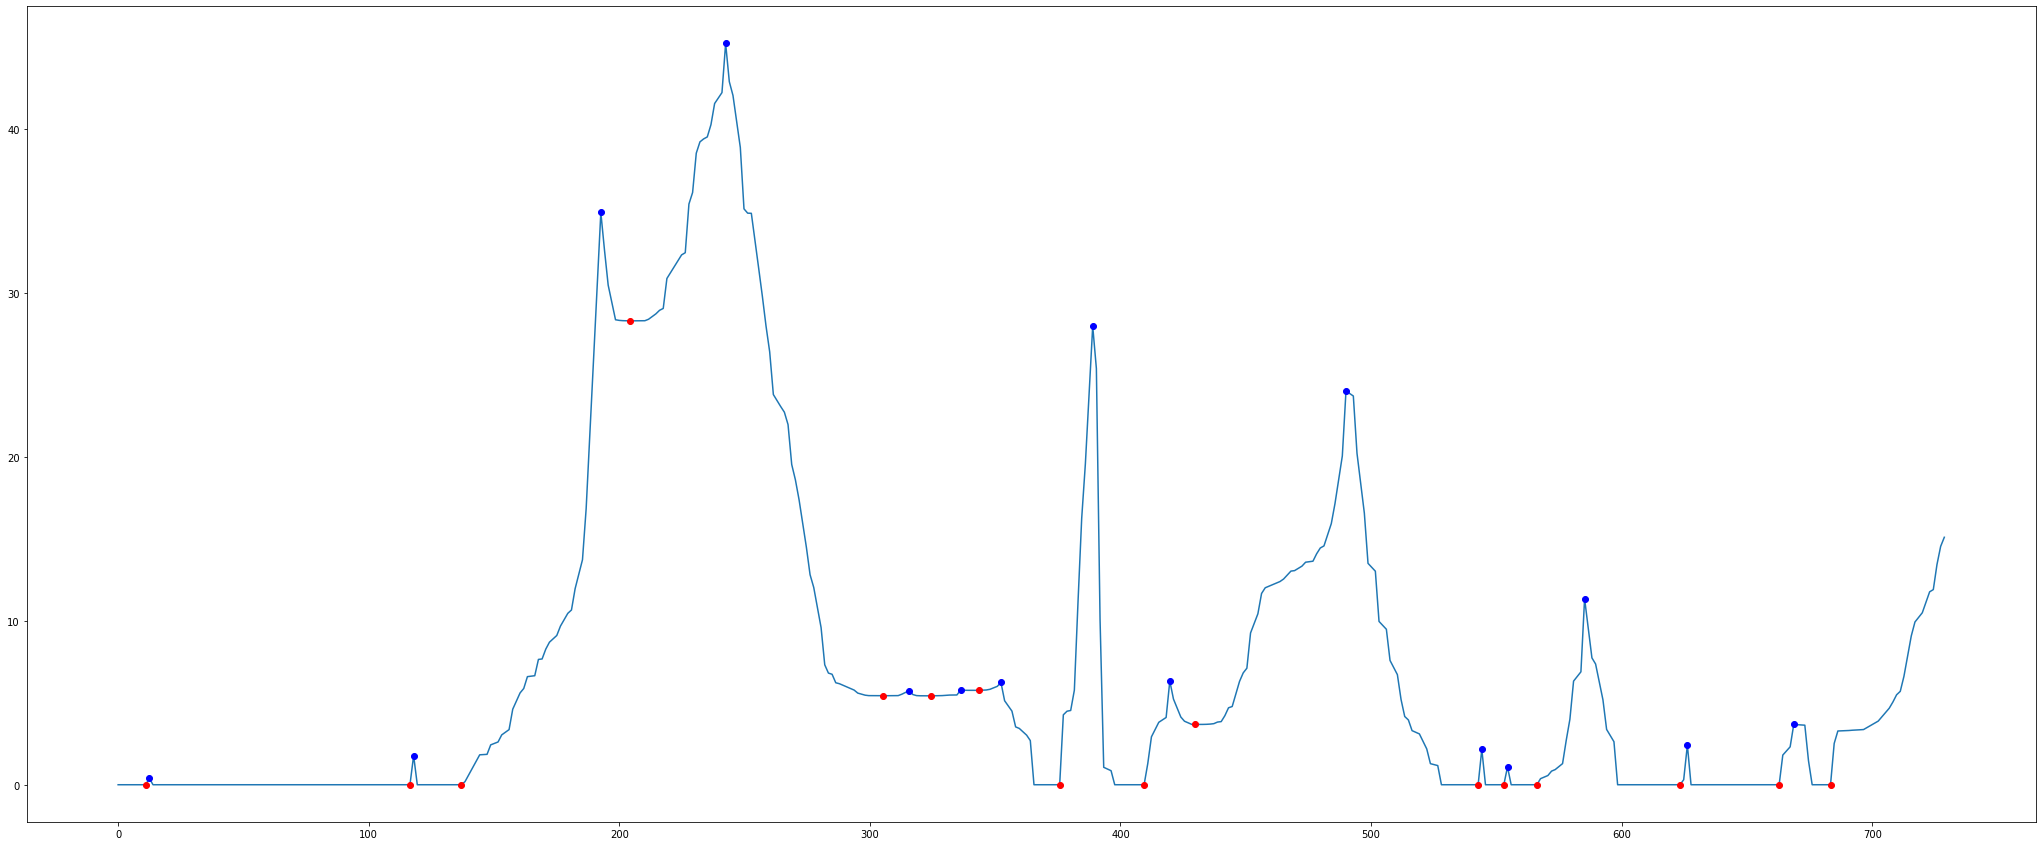

In [40]:
def get_sample_separators(sp, hz_scale):
    ys = [0]
    for pos,elem in enumerate(sp):
        if (pos>0 and pos < len(sp)-1) and (sp[pos - 1] >= elem <= sp[pos + 1]):
            if ys[-1] == pos - 1:
                ys[-1] = pos
            else:
                ys.append(pos)

    return ys

def get_groups_max(sp,sep_group):
    index = []
    value = []
    for pos, border in enumerate(sep_group):
        if pos < len(sep_group) - 1:
            value.append(max(sp[border: sep_group[pos + 1]]))
            index.append(border + np.where(sp[border: sep_group[pos + 1]] == (value[-1]))[0][0])
    return value, index

    
# data = sample_glacer(sample)
data = sample_glacer(db[1: max_val, frame].copy())
sep_group = get_sample_separators(data,hz_scale)

sep_hz = [hz_scale[i] for i in sep_group]
sep_val = [tdb[i] for i in sep_group]

max_values, max_ind = get_groups_max(data, sep_group)
max_hz = [hz_scale[i] for i in max_ind]
# print(len(max_ind)-len(max_values))
# print(len(hz_scale[2: max_val + 1])- len(tdb))
# print(len(sep_hz) - len(sep_val))
plt.figure(figsize=(36, 15))
plt.plot(hz_scale[:max_val - 1],tdb, sep_hz, sep_val, 'ro', max_hz, max_values, 'bo')


In [ ]:
db[db < 0] = 0
plt.figure(figsize=(24, 10))
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log', hop_length = int(duration*4)*39)
plt.colorbar()

In [ ]:
db[db < 0] = 0
plt.figure(figsize=(24, 10))
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log', hop_length = int(duration*4)*39)
plt.colorbar()

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/neil/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


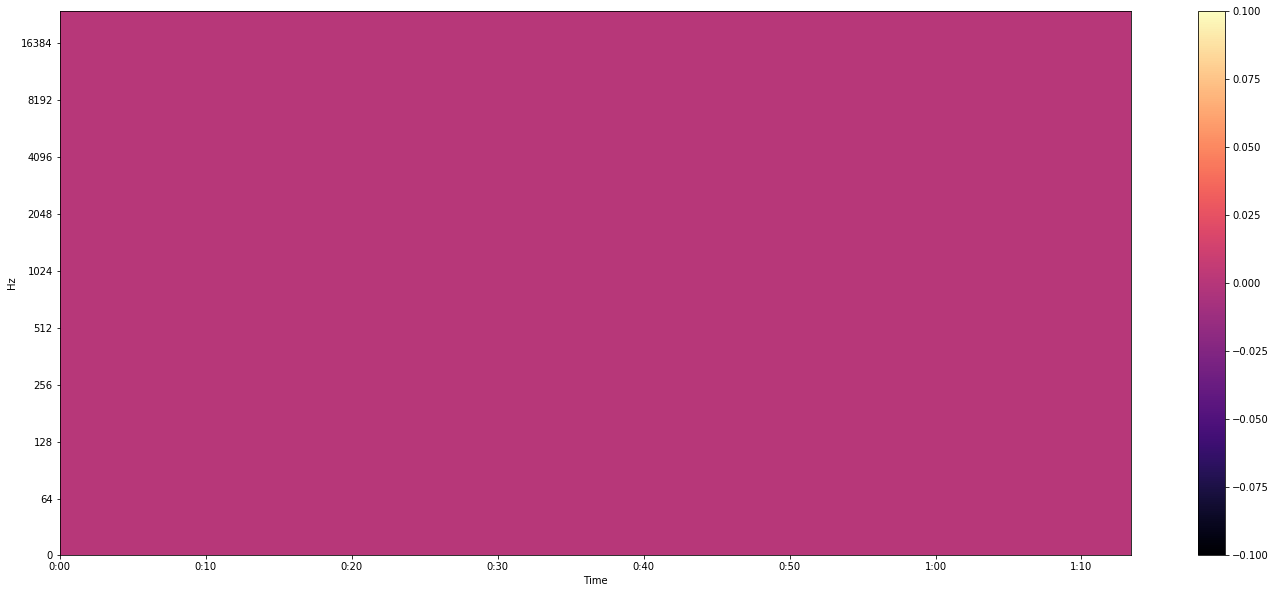

In [68]:
mean = db[db>0].mean()
db[db < mean] = 0

plt.figure(figsize=(24, 10))
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log', hop_length = int(duration*4)*39)
plt.colorbar()

In [ ]:
tdb = db_transposed = db.transpose()
# hz_scale = librosa.display.__mesh_coords('log', None, db.shape[0])

Следующий код находит все найденные звуки, но пока не производит очистки ноты от "окрестностей" по частоте, для более точного определения ноты.


In [ ]:
hertz_list = []
infinum = 40
print(db.shape)
for i in range(len(hz_scale)-1):
    if max(np.abs(db[i])) > infinum :
        hertz_list.append((i,hz_scale[i]))
for pos,hertz in hertz_list:
#     print('Max = {}; Pos = {}; Hz = {:.2f}'.format(max(np.abs(db[pos])),pos,hertz*16384/11025))
    print('Hz = {:.2f}; Db = {:.2f}; Pos = {};'.format(hertz,max(np.abs(db[pos])),pos))

In [ ]:
hz = 243.16
print('{:.2f} Hz on '.format(hz),end = '') 
# hz = int(hz*11025/16384)
lvl = list(hz_scale).index(hz_scale[abs(hz_scale-hz) < 0.5][0])
print('{}-th floor'.format(lvl))

angles = np.angle(db[lvl])
amplitudes = np.abs(db[lvl])
if max(amplitudes) > infinum:
    plt.figure(figsize = (24,8))
    plt.xlabel('Time')
    plt.ylabel('Db')
    plt.plot(time_scale[1:], amplitudes, '-r')
else:
    print('Bad Hz')

In [ ]:
print(time_scale[58], 'sec')
amplitudes = np.abs(tdb[58])
maximum = 1000

In [ ]:
peaks = []
peak_values = []
for pos in range(1, maximum-1):
    if (amplitudes[pos-1] < amplitudes[pos]) and (amplitudes[pos] > amplitudes[pos+1]):
        peaks.append(hz_scale[pos])
        peak_values.append(amplitudes[pos])


In [ ]:
plt.figure(figsize = (24,8))
plt.xlabel('Hz')
plt.ylabel('Db')
plt.plot(hz_scale[:maximum],amplitudes[:maximum],'-r',peaks,peak_values,'bo')

---
Функция нахождения ближайшего сдвига от 440 Hz (как следствие и ближайшей ноты) из формулы: **Hz ~ 440*2^(i/12)**

In [26]:
def calc_shift(base, hz):
    flag = False
    if hz > base:
        max = hz
        min = base
        flag = True
    else:
        max =base
        min = hz
    i = 0
    while max*(2**(i/12)) > min:
        i -= 1

    if max*(2**(i/12)) - min < min - max*(2**((i+1)/12)):
        less_shift = i
    else:
        less_shift = i + 1

    if flag:
        return abs(less_shift)
    else:
        return -abs(less_shift)

In [27]:
def frame_analizer(frame,hz_scale,base):
    peaks = []
    peak_values = []
    for pos in range(1, len(frame)-1):
        if (frame[pos-1] < frame[pos]) and (frame[pos] > frame[pos+1]):
            peaks.append(hz_scale[pos])
            peak_values.append(frame[pos])

    eps = 0.5
    notes = []
    for pos,info in enumerate(zip(peaks,peak_values)):
        hz,db = info
        flag = False
        for note in notes:
            if abs(hz/note - round(hz/note)) < eps:
                 flag = True
        if flag is False:
            notes.append(calc_shift(base,hz))
    return notes

In [28]:
def get_base(base_key):
    base_key_dict = {
        'skripka': 440*(2**(-5/12))
    }
    if base_key in base_key_dict:
        return base_key_dict[base_key]

In [29]:
def __song_miner__(song_amps, hz_scale,base):
    result = []
    proc_header = []
    proc_times = []
    for time,frame in enumerate(song_amps):
        proc_sample = frame_analizer(frame,hz_scale,base)
        for pos,shift in enumerate(proc_header):
            if not shift in proc_sample:
                if proc_times[pos][1] - proc_times[pos][0] > 6:
                    result.append([shift,proc_times[pos]])
                
                proc_header.remove(shift)
                proc_times.remove(proc_times[pos])
            else:
                proc_times[pos][1] += 1
                proc_sample.remove(shift)
        for shift in proc_sample:
            proc_header.append(shift)
            proc_times.append([time,time])
    return result

In [30]:
# __song_miner__(np.abs(tdb),hz_scale,get_base('skripka'))
def __song_preparation__(route, min_dur, bpm):
    sampling_rate = 48000
    audio_file , sampling_rate = librosa.load(route,sr = sampling_rate)
    duration = len(audio_file)/sampling_rate
    stft = librosa.stft(audio_file, n_fft = 2**13, hop_length = int(sampling_rate/(1/(2/min_dur/bpm))))
    db = librosa.amplitude_to_db(abs(stft))
    db[db < 0] = 0
    tdb = db.transpose()
    amplitudes = np.abs(tdb)
    plt.figure(figsize=(24, 10))
    x, time_scale, hz_scale = librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log',hop_length = int(duration*4)*5)
    plt.colorbar()
    return amplitudes,hz_scale, sampling_rate

In [31]:
def __miner_converter__(miner_results, bpm, min_dur, base_key, sampling_rate):
    t_dur = 4/min_dur
    for pos, sample in enumerate(miner_results):
        if sample[1][1] - sample[1][0] < sampling_rate/bpm*t_dur:
            del miner_results[pos]
    return miner_results

In [32]:
def song_analyzer(route,bpm,min_dur,base_key='skripka'):
    amplitudes, hz_scale, sampling_rate = __song_preparation__(route, min_dur, bpm)
    miner_results = __song_miner__(amplitudes, hz_scale, base = get_base(base_key))
    res = __miner_converter__(miner_results, bpm, min_dur, base_key, sampling_rate)
#     print(res)
    return res

/home/neil/.local/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


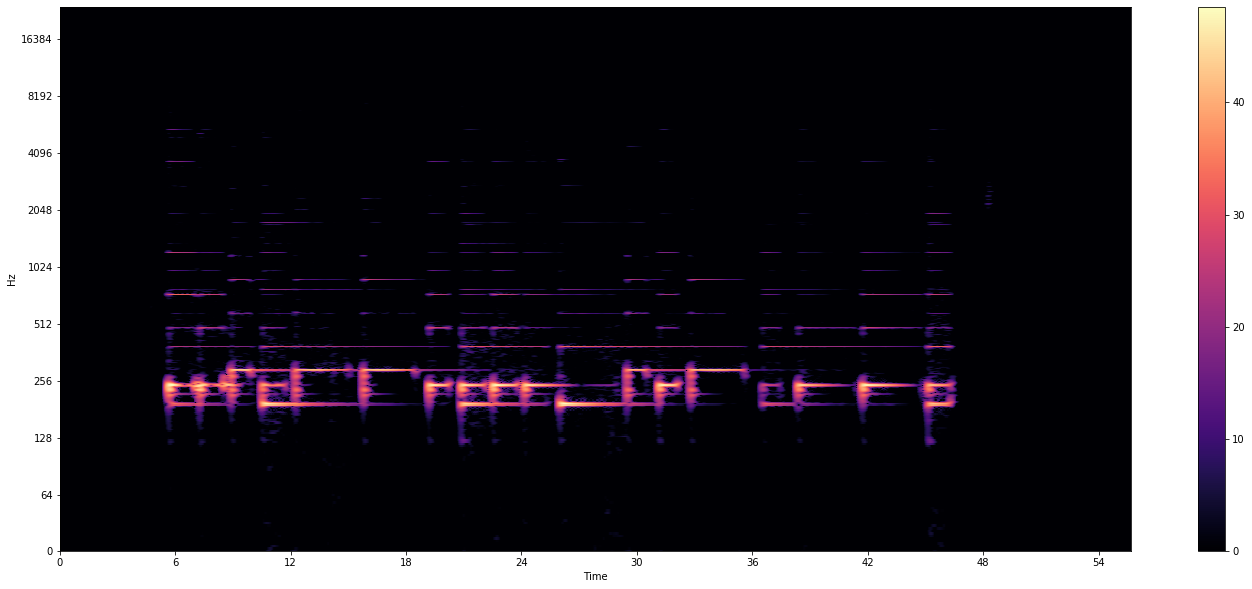

In [9]:
route = '1.ogg'
bpm = 120
min_dur = 4
res = song_analyzer(route,bpm,min_dur)
# 48000/(1/(2/4/bpm))

In [34]:
res_dots = [[440*(2**(-5/12))*2**(i[0]/12),i[1][0]/200,(i[1][1]-i[1][0])/200] for i in res]
# temp = set([i[0] for i in res_dots])
# print(len(temp))
res_dots
# res

[[174.61411571650194, 2.76, 0.045],
 [65.40639132514966, 2.915, 0.075],
 [184.9972113558172, 3.085, 0.385],
 [123.47082531403103, 3.655, 0.065],
 [116.54094037952248, 3.85, 0.06],
 [130.8127826502993, 4.525, 0.195],
 [207.65234878997256, 5.165, 0.05],
 [123.47082531403103, 5.3, 0.045],
 [29.13523509488062, 5.39, 0.195],
 [4.5885119987094924, 5.65, 0.205],
 [138.59131548843604, 5.925, 0.075],
 [164.81377845643496, 6.095, 0.04],
 [164.81377845643496, 6.205, 0.04],
 [1.531232171803708, 6.32, 0.04],
 [184.9972113558172, 6.68, 0.28],
 [7.716926582126938, 7.1, 0.07],
 [51.91308719749314, 7.235, 0.125],
 [87.30705785825097, 7.505, 0.095],
 [110.0, 7.71, 0.055],
 [130.8127826502993, 8.04, 0.1],
 [184.9972113558172, 8.24, 1.445],
 [130.8127826502993, 9.79, 0.07],
 [116.54094037952248, 9.91, 0.065],
 [207.65234878997256, 10.3, 0.17],
 [41.20344461410874, 10.685, 0.1],
 [103.82617439498628, 10.895, 0.085],
 [65.40639132514966, 11.075, 0.045],
 [138.59131548843604, 11.28, 0.06],
 [130.812782650299

In [64]:
def data_converter(data):
    for pos, elem in data:
        elem.append(elem[1][0])/
#         elem[1] = (elem[1][1] - elem[1][0])
    
    answer = []
    diction = {'key':'skripka','content':[]}
    content = {'points':[]}
    
    points = 
    return answer

SyntaxError: invalid syntax (<ipython-input-64-fd8792cc6470>, line 3)

---
## Исправить работу следующего кода! Некорректные показания!

In [ ]:
t = 4.72875
frame = int(t/duration*db.shape[1])
# frame =36
t_h_graph = np.abs(db.transpose()[frame])
print(frame)
print('Time = {}'.format(t))
# if max(t_h_graph) > infinum:

# xfirst = [334.862706*i*11025/16384 for i in range(1,14)]
# yfirst = [30,22,17,25,30,36,0,21,16,9,29,26,14]
# 669, 334

xfirst = [328.86*i for i in range(1,13)]
yfirst = [36,13,5,15,20,25,0,12,0,0,18,17]

plt.figure(figsize = (24,8))
plt.plot(hz_scale[:3000],t_h_graph[:3000],xfirst,yfirst,'ro')

# else:
#     print('Bad Time')

In [ ]:
def getmax(tmp, *argz):
    if len(tmp) == 0:
        if len(argz) == 1:
            return round(argz[0])
        else:
            return 0
    else:
        return tmp.max()

In [ ]:
# hertz to frame:
# F = Hz * 11025 / 16384
def discrete_plot(hz_scale, t_h_graph, L):
    test_th = t_h_graph.copy()
    c = 2**(1/12)
#     a = 12*math.log2(0.5 + c/2)
    a = 1/2
    b = 11025 / 16384;


    # |[0,a] 2**(x/12) dx = |[a,1] 2**(x/12) dx
    for i in range(-57,51):
        curr_Hz    = 440 * (2**(i/12))
        curr_frame = round(curr_Hz * b)
    #     RadiusPositive, RadiusNegative
        Rp = curr_Hz*a*(1 + c)
        Rn = curr_Hz*(1-a)*(1 + 1 / c)

        left_Hz  = curr_Hz - Rn
        right_Hz = curr_Hz + Rp

        left_frame  = round(Rn * b) + 1
        right_frame = round(Rp * b) - 1

        new_val = getmax(t_h_graph[left_frame:right_frame], t_h_graph[curr_frame])
    #     for frame in range(left_frame,right_frame + 1):
    #         test_th[frame] = 0
        prev_Hz = curr_Hz* (2**(-1/12))
        prev_frame = round(prev_Hz * b)
        for frame in range(prev_frame + 1, curr_frame):
            test_th[frame] = 0
        test_th[curr_frame] = new_val
#         print('Changes at {:.3f} Hz ({} frame)'.format(curr_Hz, curr_frame), end = '')
#         print('\t({};{})'.format(left_frame,right_frame), end ='')
#         print('\t [{}->{}]'.format(t_h_graph[curr_frame],test_th[curr_frame]))
    plt.figure(figsize = (24,8))
    plt.plot(hz_scale[:L],test_th[:L])

In [ ]:
test_th = t_h_graph.copy()
dots = [] 
L = 6500
delta = 10
for pos,elem in enumerate(test_th):
    if pos < delta:
        tmp1 = t_h_graph[:pos-1]
        tmp2 = t_h_graph[pos+1:pos+delta]
        if getmax(tmp1) < elem and getmax(tmp2) < elem:
            dots.append(pos)
    elif pos > len(test_th) -delta:
        tmp1 = t_h_graph[pos - delta:pos-1]
        tmp2 = t_h_graph[pos+1:pos+delta]
        if getmax(tmp1) < elem and getmax(tmp2) < elem:
            dots.append(pos)
    else :
        tmp1 = t_h_graph[pos-delta:pos]
        tmp2 = t_h_graph[pos+1:pos+delta]
#         if pos == 452:
#             print(tmp1,tmp2)
        if getmax(tmp1) < elem and getmax(tmp2) < elem:
            dots.append(pos)

ys = [t_h_graph[i] for i in dots]
l = len([i for i in dots if i < L])
plt.figure(figsize = (24,8))
plt.plot(hz_scale[:L],t_h_graph[:L])
discrete_plot(hz_scale, t_h_graph, L)

In [ ]:
plt.figure(figsize=(24, 8))
# plt.plot(audio_file[start_timestamp:end_timestamp])
plt.plot(audio_file)

In [ ]:
plt.figure(figsize=(24, 8))
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

Примечания программиста:
    - Чистая нота даёт ровные обертона не отличающиеся по децибелам на спектрограммах
    - Когда параллельно звучит нота А,B Hz: A*n = B, то имеет место интерференция двух синусоид (sin(wt+u)+sin(wt+v)), что пораждает биения!
    - Требуется дополнительное изучение природы, чтобы научиться отличать между собой множество нот из одной гармоники

# Запись

In [ ]:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()